## Setup

In [36]:
!pip install datasets jiwer Levenshtein --quiet

In [37]:
import torch, datasets
from torch import nn
import torchaudio
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
from jiwer import compute_measures, cer

In [38]:
# Sync with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Load **testing** dataset

In [40]:
SAMPLE_IDX = 16

In [41]:
DATASET_DIR = "drive/MyDrive/MLMI2/proc_data/mfcc_dataset"
TRAINING_DIR = "drive/MyDrive/MLMI2/training"
REMOTE_MFCC_FEATURES_DIR = "drive/MyDrive/MLMI2/proc_data/mfcc_features"

In [42]:
# Unzip TEST.zip
!unzip -q drive/MyDrive/MLMI2/raw_data/wav/TEST.zip -d ./wav/
!unzip -q {REMOTE_MFCC_FEATURES_DIR}/mfcc_features.zip -d .

replace ./wav/TEST/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ./mfcc_features/MKAM0_SI1465.WAV.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [43]:
# Load dataset from disk
test_dataset = datasets.load_from_disk(DATASET_DIR)['test']

In [44]:
WAV_DIR = test_dataset[SAMPLE_IDX]['wav']

In [45]:
# Get token to phone vocabulary (dictionary)
with open('drive/MyDrive/MLMI2/proc_data/vocab_39.txt') as f:
  vocab = f.read().splitlines()
  vocab_idx_to_phn = {k: v for k, v in enumerate(vocab)}

In [46]:
waveform , sample_rate = torchaudio.load(WAV_DIR)
waveform_np = waveform.numpy()[0]

In [87]:
with open(WAV_DIR.replace('.WAV', '.PHN'), 'r') as f:
  phn_labels = f.read().splitlines()
  phn_labels = [i.split() for i in phn_labels]
  phn_labels = [(int(i[0])/samp_rate, int(i[1])/samp_rate, i[2]) for i in phn_labels]

### Load trained model

In [47]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, nb_hidden, output_size, is_bidirectional, dropout_rate):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, nb_hidden, dropout=dropout_rate, bidirectional=is_bidirectional)
        if is_bidirectional:
          self.fc = nn.Linear(hidden_size*2, output_size)
        else:
          self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden, _ = self.lstm(x)
        out = self.fc(hidden)
        return out

In [48]:
model = MyLSTM(23, 128, 1, 40, True, 0.0)
model.load_state_dict(torch.load(f'{TRAINING_DIR}/trained_model.pt', map_location=torch.device('cpu')))

<ipython-input-48-7ea796a9374e>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

### Decode all testing sequences

In [82]:
def get_sequence_probabilities(model, sample):
  input = torch.load(sample['mfcc_path']).to(DEVICE)
  with torch.no_grad():
    output_softmax = torch.nn.functional.softmax(model(input), dim=-1)
    output = list(int(i) for i in torch.argmax(output_softmax, dim=-1))
  return output_softmax, output

In [85]:
def decode(sample, model, vocab_idx_to_phn):
  # Get argmaxed model outputs
  _, output = get_sequence_probabilities(model, sample)
  # Re-format model outputs
  output = [output[0]] + [output[i] for i in range(1, len(output)) if output[i] != output[i - 1]] # Delete consequitive duplicates
  output = [i for i in output if i != 0]          # Remove the blank spaces
  output = [vocab_idx_to_phn[i] for i in output]  # Transform from tokens to phones
  output = ' '.join(output)
  sample['output'] = output
  return sample

In [86]:
test_dataset = test_dataset.map(lambda sample: decode(sample, model, vocab_idx_to_phn))

Map:   0%|          | 0/944 [00:00<?, ? examples/s]

<ipython-input-82-630a188c6cc5>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [52]:
  #   if char:
  #     cur_stats = cer(true_labels, output, return_dict=True)
  #   else:
  #     cur_stats = compute_measures(true_labels, output)

  #   stats[0] += cur_stats["substitutions"]
  #   stats[1] += cur_stats["deletions"]
  #   stats[2] += cur_stats["insertions"]
  #   stats[3] += cur_stats["hits"]

  # total_words = stats[0] + stats[1] + stats[3]
  # sub = stats[0] / total_words * 100
  # dele = stats[1] / total_words * 100
  # ins = stats[2] / total_words * 100
  # cor = stats[3] / total_words * 100
  # err = (stats[0] + stats[1] + stats[2]) / total_words * 100
  # return sub, dele, ins, cor, err

## Experiments

### Visualisation

#### Heatmap

In [53]:
output_softmax = get_sequence_probabilities(model, test_dataset[SAMPLE_IDX])[0].transpose(1,0)
output_softmax = output_softmax.cpu().detach().numpy()
output_softmax.shape

<ipython-input-49-6bbf0c2b8ede>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



(40, 167)

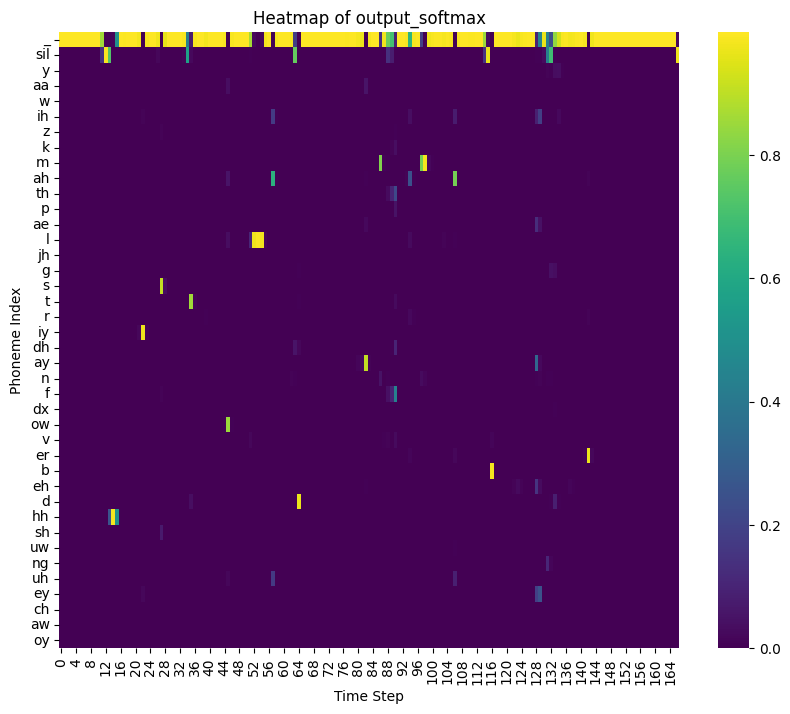

In [54]:
# Make a heatmap for output_softmax
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(output_softmax, annot=False, cmap="viridis", fmt=".2f", yticklabels=vocab)
plt.title("Heatmap of output_softmax")
plt.xlabel("Time Step")
plt.ylabel("Phoneme Index")
plt.show()

In [55]:
output_softmax.transpose(1,0).shape

(167, 40)

#### Network output distributions

In [62]:
# Define the duration for each time step in seconds
time_step_duration = 0.01  # 10 milliseconds

# Create the time axis for output_softmax
output_time_axis = np.arange(output_softmax.shape[1]) * time_step_duration

# Create the time axis for the waveform
# Assuming `waveform_np` has a sampling rate (e.g., 16000 samples/sec)
sampling_rate = 16000  # Replace with your actual waveform sampling rate
waveform_duration = len(waveform_np) / sampling_rate  # Total duration of waveform in seconds
waveform_time_axis = np.linspace(0, waveform_duration, len(waveform_np))  # Time axis for waveform

# Create a subplot with shared x-axis
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True)  # Share x-axis

# Add the first plot (output_softmax)
for i in range(40):
    line_style = 'solid'
    line_color = None
    if vocab[i] == '_':
        line_style = 'dot'
        line_color = 'grey'
    fig.add_trace(go.Scatter(
        x=output_time_axis,  # Use the converted time axis
        y=output_softmax[i],
        mode='lines',
        name=vocab[i],
        line=dict(dash=line_style, color=line_color),
        line_width=2
    ), row=1, col=1)  # Specify subplot location

# Add the second plot (waveform)
fig.add_trace(go.Scatter(
    x=waveform_time_axis,  # Use the full waveform time axis
    y=waveform_np,
    mode='lines',
    name='Waveform',
    line=dict(color='blue', width=0.001)
), row=2, col=1)  # Specify subplot location

# Update layout
fig.update_layout(
    title=dict(text="Frame-level Phone Probability and Corresponding Waveform", x=0.5, xanchor='center'),
    xaxis_title="Time (seconds)",  # Use seconds for x-axis label
    yaxis_title="Probability",  # y-axis label for the first subplot
    yaxis2_title="Amplitude",  # y-axis label for the second subplot
    width=1000,
    height=1000
)

# Show the plot
fig.show()

#### Confusion matrix

In [57]:
predicted_phn_list = test_dataset['output']
target_phn_list = test_dataset['phn']

In [58]:
print(predicted_phn_list[0])
print(target_phn_list[0])

sil ae sil t w aa l ey sil t ah m ah sil w aa f sil dh ey l ah v ah sil b l iy sil
sil ae sil t sil w aa l ay sil t ah m ah sil t sil w eh l th sil d ey w l hh ae v sh ah sil b l iy sil


In [59]:
# predicted_tokens = [item for sublist in predicted_tokens for item in sublist]
# target_tokens = [item for sublist in target_tokens for item in sublist]

In [60]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(target_tokens, predicted_tokens)

In [61]:
from Levenshtein import editops

def create_confusion_matrix(target_phn_list, predicted_phn_list, vocabulary):
  """
  Calculates a confusion matrix for phone recognition.

  Args:
    target_phn_list: A list of reference phone sequences (ground truth).
    predicted_phn_list: A list of predictedothesized phone sequences (model predictions).
    vocabulary: A list of all possible phones.

  Returns:
    A confusion matrix (list of lists) with dimensions (V+1) x (V+1),
    where V is the vocabulary size.
  """

  # Add 'insertion' and 'deletion' to the vocabulary
  vocab_with_edits = vocabulary + ['insertion', 'deletion']
  vocab_size = len(vocab_with_edits)

  # Initialize the confusion matrix with zeros
  confusion_matrix = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]

  # Iterate through each reference-hypothesis pair
  for target, predicted in zip(target_phn_list, predicted_phn_list):
    ops = editops(target, predicted)
    print(ops)
    for op, target_pos, predicted_pos in ops:
      if op == 'replace':
        target_phn = target[target_pos]
        predicted_phn = predicted[predicted_pos]
        print(target_phn)
        print(predicted_phn)
        print(vocab_with_edits.index(target_phn))
        print(vocab_with_edits.index(predicted_phn))
        confusion_matrix[vocab_with_edits.index(target_phn)][vocab_with_edits.index(predicted_phn)] += 1
      elif op == 'insert':
        predicted_phn = predicted[predicted_pos]
        confusion_matrix[vocab_with_edits.index('insertion')][vocab_with_edits.index(predicted_phn)] += 1
      elif op == 'delete':
        target_phn = target[target_pos]
        confusion_matrix[vocab_with_edits.index(target_phn)][vocab_with_edits.index('deletion')] += 1

  return confusion_matrix


confusion_matrix = create_confusion_matrix(target_phn_list[0], predicted_phn_list[0], list(vocab_idx_to_phn.values()))

# Print the confusion matrix (you might want to format it better)
for row in confusion_matrix:
  print(row)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[('replace', 0, 0)]
s
w
16
4
[('replace', 0, 0)]
i
 


ValueError: 'i' is not in list

In [63]:
test_dataset

Dataset({
    features: ['wav', 'duration', 'spk_id', 'phn', 'wrd', 'sample_id', 'tokens', 'mfcc_path', 'output'],
    num_rows: 944
})

In [111]:
l = []
for sample in test_dataset:
  dec = decode(sample, model, vocab_idx_to_phn)['output']
  target = sample['phn']
  res = compute_measures(target, dec)
  l.append((res["substitutions"] + res["deletions"] + res["insertions"]) / (res["substitutions"] + res["deletions"] + res["hits"]) * 100)

print(np.argmax(l))

<ipython-input-82-630a188c6cc5>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



778


In [112]:
l[16]

84.61538461538461

In [113]:
test_dataset[778]

{'wav': 'wav/TEST/DR2/MDLD0/SI1543.WAV',
 'duration': 2.233625,
 'spk_id': 'MDLD0',
 'phn': 'sil dh eh n hh iy sil dh eh n w ah sil',
 'wrd': 'then he then what',
 'sample_id': 'MDLD0_SI1543.WAV',
 'tokens': [1, 20, 29, 22, 31, 19, 1, 20, 29, 22, 4, 9, 1],
 'mfcc_path': 'mfcc_features/MDLD0_SI1543.WAV.pt',
 'output': 'ae eh aa sil'}

In [66]:
sample = test_dataset[0]

In [76]:
sample

{'wav': 'wav/TEST/DR1/MDAB0/SX49.WAV',
 'duration': 2.201625,
 'spk_id': 'MDAB0',
 'phn': 'sil ae sil t sil w aa l ay sil t ah m ah sil t sil w eh l th sil d ey w l hh ae v sh ah sil b l iy sil',
 'wrd': "at twilight on the twelfth day we'll have chablis",
 'sample_id': 'MDAB0_SX49.WAV',
 'tokens': [1,
  12,
  1,
  17,
  1,
  4,
  3,
  13,
  21,
  1,
  17,
  9,
  8,
  9,
  1,
  17,
  1,
  4,
  29,
  13,
  10,
  1,
  30,
  36,
  4,
  13,
  31,
  12,
  26,
  32,
  9,
  1,
  28,
  13,
  19,
  1],
 'mfcc_path': 'mfcc_features/MDAB0_SX49.WAV.pt',
 'output': 'sil ae sil t w aa l ey sil t ah m ah sil w aa f sil dh ey l ah v ah sil b l iy sil'}

In [80]:
with open(sample['wav'].replace('.WAV', '.PHN'), 'r') as f:
  _, samp_rate = torchaudio.load(sample['wav'])

  phn_labels = f.read().splitlines()
  phn_labels = [i.split() for i in phn_labels]
  phn_labels = [(int(i[0])/samp_rate, int(i[1])/samp_rate, i[2]) for i in phn_labels]

  print(phn_labels)

[(0.0, 0.145, 'h#'), (0.145, 0.25325, 'ae'), (0.25325, 0.31625, 'tcl'), (0.31625, 0.37, 't'), (0.37, 0.41, 'epi'), (0.41, 0.4343125, 'w'), (0.4343125, 0.5169375, 'aa'), (0.5169375, 0.585, 'l'), (0.585, 0.67, 'ay'), (0.67, 0.705625, 'tcl'), (0.705625, 0.743125, 't'), (0.743125, 0.7975, 'ax'), (0.7975, 0.831375, 'm'), (0.831375, 0.872625, 'ax'), (0.872625, 0.8903125, 'tcl'), (0.8903125, 0.960375, 't'), (0.960375, 1.0, 'epi'), (1.0, 1.03, 'w'), (1.03, 1.0899375, 'eh'), (1.0899375, 1.1225, 'l'), (1.1225, 1.1575, 'th'), (1.1575, 1.2155625, 'dcl'), (1.2155625, 1.2425, 'd'), (1.2425, 1.367875, 'ey'), (1.367875, 1.40725, 'w'), (1.40725, 1.4595, 'el'), (1.4595, 1.5205625, 'hv'), (1.5205625, 1.595, 'ae'), (1.595, 1.621375, 'v'), (1.621375, 1.7310625, 'sh'), (1.7310625, 1.7675, 'ax'), (1.7675, 1.816875, 'bcl'), (1.816875, 1.834375, 'b'), (1.834375, 1.90075, 'l'), (1.90075, 2.0148125, 'iy'), (2.0148125, 2.195, 'h#')]


In [74]:
len(sample['tokens'])

36

In [114]:
import numpy as np
from sklearn.metrics import confusion_matrix
from nltk.metrics import edit_distance

# Example: Predictions and Targets
predictions = "hllo aze azea zeaze  wrld"  # Model output
targets = "hello world"    # Ground truth

total_aligned_preds = []
total_aligned_targets = []

for sample in test_dataset:

  predictions = sample['output'].split(' ')
  targets = sample['phn'].split(' ')

  # Align sequences using edit distance and track errors
  aligned_preds = []
  aligned_targets = []

  i, j = 0, 0
  while i < len(predictions) or j < len(targets):
      if i < len(predictions) and j < len(targets) and predictions[i] == targets[j]:
          # Match
          aligned_preds.append(predictions[i])
          aligned_targets.append(targets[j])
          i += 1
          j += 1
      elif j < len(targets) and (i >= len(predictions) or edit_distance(predictions[i:], targets[j + 1:]) <= edit_distance(predictions[i + 1:], targets[j:])):
          # Deletion (target exists, prediction missing)
          aligned_preds.append("<delete>")
          aligned_targets.append(targets[j])
          j += 1
      elif i < len(predictions):
          # Insertion or substitution
          aligned_preds.append(predictions[i])
          if j < len(targets):
              # Substitution
              aligned_targets.append(targets[j])
              j += 1
          else:
              # Insertion
              aligned_targets.append("<insert>")
          i += 1

  total_aligned_preds.extend(aligned_preds)
  total_aligned_targets.extend(aligned_targets)
  print('o', end=' ')


# Define all unique labels (including errors)
vocab = open('drive/MyDrive/MLMI2/proc_data/vocab_39.txt').read().splitlines()
labels = list(set(vocab) | {"<delete>", "<insert>"})

# Build confusion matrix
cm = confusion_matrix(total_aligned_targets, total_aligned_preds, labels=labels)

# Display confusion matrix
print("Labels:", labels)
print("Confusion Matrix:\n", cm)


o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o 

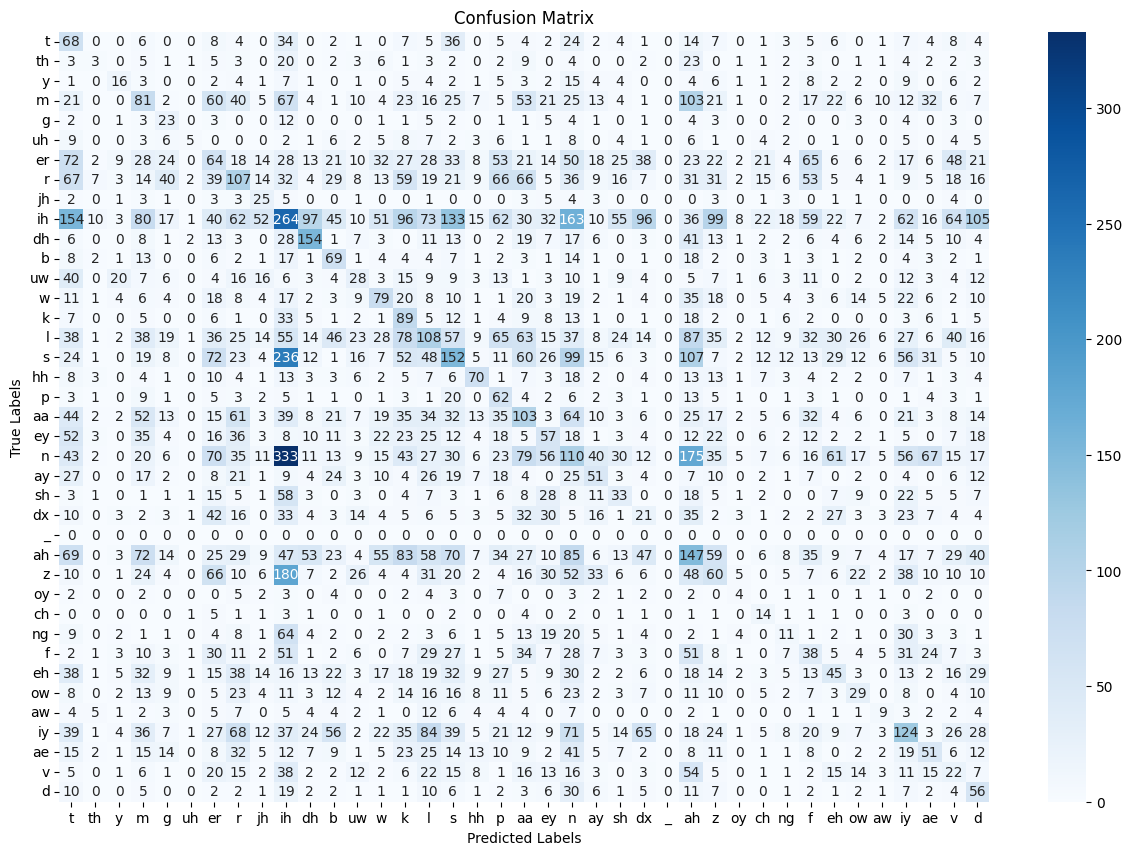

In [122]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [117]:
labels_to_drop = ['<delete>', '<insert>', 'sil']

for label_to_drop in labels_to_drop:
  if label_to_drop in labels:  # Check if label is present
    label_index = labels.index(label_to_drop)
    labels.pop(label_index)
    cm = np.delete(cm, label_index, axis=0)  # Remove row
    cm = np.delete(cm, label_index, axis=1)  # Remove column

# Display the updated confusion matrix
print("Labels:", labels)
print("Confusion Matrix:\n", cm)

Labels: ['t', 'th', 'y', 'm', 'g', 'uh', 'er', 'r', 'jh', 'ih', 'dh', 'b', 'uw', 'w', 'k', 'l', 's', 'hh', 'p', 'aa', 'ey', 'n', 'ay', 'sh', 'dx', '_', 'ah', 'z', 'oy', 'ch', 'ng', 'f', 'eh', 'ow', 'aw', 'iy', 'ae', 'v', 'd']
Confusion Matrix:
 [[68  0  0 ...  4  8  4]
 [ 3  3  0 ...  2  2  3]
 [ 1  0 16 ...  0  6  2]
 ...
 [15  2  1 ... 51  6 12]
 [ 5  0  1 ... 15 22  7]
 [10  0  0 ...  2  4 56]]


In [110]:
probs = get_sequence_probabilities(model, test_dataset[0])[0]

<ipython-input-82-630a188c6cc5>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

